<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/makeblobs_pca_xgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo with Kidney stone data set
Data source is [here](https://www.kaggle.com/datasets/vuppalaadithyasairam/kidney-stone-prediction-based-on-urine-analysis
).

In [ ]:
# Last amended: 6th June, 2023

## Basics

In [65]:
%reset -f

In [66]:
!pip install catencfamily

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [67]:
# 1.0 Call libraries
import pandas as pd
import numpy as np


# 1.01
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA


# 1.02
import matplotlib.pyplot as plt
import seaborn as sns


# 1.03
import xgboost as xgb


# 1.04
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils

In [4]:
# 1.05 Display multiple commands output from a cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [194]:
X1, y = make_blobs(
                   n_samples=10000,
                   n_features=6 ,
                   centers= 2,
                   cluster_std=1
                   )


In [195]:
cols = ["c" + str(i) for i in 'abcdef']
data = pd.DataFrame(X1, columns = list('abcdef'))
data['target'] = y

In [196]:
# 2.1
data.head()


,a,b,c,d,e,f,target
0,-2.572410,-9.417623,8.890708,6.952229,6.788774,2.687564,1
1,-0.008222,-9.812491,8.603283,6.293379,8.899394,3.151038,1
2,8.142096,7.238543,-7.819052,6.365131,-4.691461,2.984011,0
3,-2.133423,-10.603513,8.717422,7.555699,9.369813,3.700943,1
4,-1.903432,-10.309939,8.347550,6.243532,8.593642,2.888605,1


In [197]:
# 2.21 Proportions of 1s and 0s

data['target'].value_counts(normalize = True)

1    0.5
0    0.5
Name: target, dtype: float64

In [198]:
# 2.3 Check nulls and any need for imputing?

data.isnull().sum().sum()


0

## Transform numeric data to categorical
We transform our data as if it were categorical. (of course, such transformation is imperfect.)

To perform our experiments we bin all numeric columns to transform the data to categorical. Binning is performed using pandas `cut()` method. Subsequently we will transform the categorical data to numeric using the approach given in CatEncodersFamily.  

While binning, we also split the data: both the numeric (the original) as also the binned datasets. Spliting is performed in stratified manner using `train_test_split()` function of sklearn; `target (y)` is used to stratify. While splitting, for easy comparison, we  see to it that same set of rows occur in `orig_train` and `train_binned` on the one hand and `orig_test` and `test_binned` on the other hand. 

In [215]:
# 3.0 Discretise all features of data. And also split dataset.
#     into train/test:

orig_train, orig_test, train_binned, test_binned  = utils.transformToCatFeatures(data,
                                                                              y,
                                                                              bins = 60,
                                                                              test_size = 0.1,
                                                                              genColName = False  # Keep orig col names
                                                                              )

In [216]:
# 3.0.1 Check  original data:
#       It has target col also:

orig_train.shape
print("\n======\n")
orig_train.head(3)
orig_test.head(3)


(9000, 7)

,a,b,c,d,e,f,target
4852,-0.587038,-8.598581,9.891363,8.018590,9.425624,3.719523,1
9638,-1.097333,-9.826051,7.243083,7.749656,6.661405,3.317026,1
8704,-0.032631,-7.533373,7.816710,6.487245,10.619312,2.861628,1


,a,b,c,d,e,f,target
755,-2.572410,-9.417623,8.890708,6.952229,6.788774,2.687564,1
2115,-0.008222,-9.812491,8.603283,6.293379,8.899394,3.151038,1
5713,8.142096,7.238543,-7.819052,6.365131,-4.691461,2.984011,0


In [217]:
# 3.0.2 Check discretised features
#       Note the row-indices of train/test data 
#       and compare with those in the above cell.

train_binned.shape
print("\n========\n")
train_binned.head(3)
test_binned.head(3)

(9000, 7)

,a,b,c,d,e,f,target
4852,416,812,1255,1643,2050,2430,1
9638,414,89,1248,1641,2043,2427,1
8704,418,815,1250,1631,2053,2423,1


,a,b,c,d,e,f,target
755,49,810,1252,1634,2043,2422,1
2115,418,89,1251,1629,2049,2426,1
5713,446,854,1211,1630,2013,2424,0


In [218]:
# 3.1 Pop out targets:

ytr = train_binned.pop('target')
yte = test_binned.pop("target")

## Transform categorical data to numeric
We use `CatEncodersFamily` class for transformation:

In [219]:
## 4.0 Developing models
#      Which are our cat columns


cat_cols = list(train_binned.columns)
len(cat_cols)  # 6


# 4.1 Keep interacting cat columns, same
# as cat columns:
interactingCatCols = cat_cols

6

In [220]:
# 5.0 Instantiate CatEncodersFamily class:

ct = CatEncodersFamily(
                       cMeasures=[1,1,1,1,None,1,1],
                       )

# 5.1 Fit it using only train_binned dataset.
#     While fitting, 'target' is not needed:


ct.fit(train_binned, cat_cols, interactingCatCols) 

Record set no is 1  
Set of records is:  [('a', 'b', [1, 1, 1, 1, None, 1, 1]), ('a', 'c', [1, 1, 1, 1, None, 1, 1]), ('a', 'd', [1, 1, 1, 1, None, 1, 1]), ('a', 'e', [1, 1, 1, 1, None, 1, 1]), ('a', 'f', [1, 1, 1, 1, None, 1, 1]), ('a', 'b_p_f', [1, 1, 1, 1, None, 1, 1]), ('a', 'b_p_e', [1, 1, 1, 1, None, 1, 1]), ('a', 'a_p_b', [1, 1, 1, 1, None, 1, 1]), ('a', 'a_p_e', [1, 1, 1, 1, None, 1, 1]), ('a', 'a_p_c', [1, 1, 1, 1, None, 1, 1]), ('a', 'c_p_d', [1, 1, 1, 1, None, 1, 1]), ('a', 'e_p_f', [1, 1, 1, 1, None, 1, 1]), ('a', 'd_p_e', [1, 1, 1, 1, None, 1, 1]), ('a', 'd_p_f', [1, 1, 1, 1, None, 1, 1]), ('a', 'b_p_c', [1, 1, 1, 1, None, 1, 1]), ('a', 'c_p_e', [1, 1, 1, 1, None, 1, 1]), ('a', 'c_p_f', [1, 1, 1, 1, None, 1, 1]), ('a', 'a_p_d', [1, 1, 1, 1, None, 1, 1]), ('a', 'b_p_d', [1, 1, 1, 1, None, 1, 1]), ('a', 'a_p_f', [1, 1, 1, 1, None, 1, 1]), ('b', 'a', [1, 1, 1, 1, None, 1, 1]), ('b', 'c', [1, 1, 1, 1, None, 1, 1]), ('b', 'd', [1, 1, 1, 1, None, 1, 1]), ('b', 'e', [1, 1, 1, 1, 

CatEncodersFamily(cMeasures=[1, 1, 1, 1, None, 1, 1],
                  pathToStoreProgress=PosixPath('/content/allmodels/progress'))

## Data transformation:

In [221]:
# 6.0 Transform both test_binned and train_binned data:

test_trans = ct.transform(test_binned)

f"Transformed test data shape: {test_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  600
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 3.869504 MB
Mem usage after dtype transformation is: 1.949504 MB


'Transformed test data shape: (1000, 486)'

In [222]:
# 6.0.1 Transform train_binned now:

train_trans= ct.transform(train_binned[cat_cols])

f"Transformed train data shape: {train_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  600
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 34.701504 MB
Mem usage after dtype transformation is: 17.421504 MB


'Transformed train data shape: (9000, 486)'

Our new features are substantially difft from original features. Prefixes to feature names imply as below:  
<i>
>deg_ ===> This feature results from calculation of degree centrality<br>
>eig_ ===> This feature results from calculation of eigenvector centrality<br>
>pr_  ===> This feature results from calculation of page rank centrality<br>
>bet_ ===> This feature results from calculation of betweenness centrality<br>
>clu_ ===> This feature results from calculation of clustering characteristics<br>,</i>


In [223]:
# 6.1 Observe data now:
#     It also has original binned cols (5):

train_trans.head()
test_trans.head()

,a,b,c,d,e,f,deg_a_ck_b,eig_a_ck_b,pr_a_ck_b,clu_a_ck_b,...,eig_f_ck_a_p_d,pr_f_ck_a_p_d,clu_f_ck_a_p_d,bet_f_ck_a_p_d,deg_f_ck_b_p_d,eig_f_ck_b_p_d,pr_f_ck_b_p_d,clu_f_ck_b_p_d,bet_f_ck_b_p_d,eig_f_ck_a_p_f
0,416,812,1255,1643,2050,2430,0.510204,2.006215e-01,0.020496,0.97000,...,0.158582,0.023060,0.779592,0.013476,0.962963,0.159374,0.023034,0.770739,0.011838,-0.124528
1,414,89,1248,1641,2043,2427,0.510204,2.006215e-01,0.020496,0.97000,...,0.160176,0.022775,0.795102,0.008909,0.981481,0.161082,0.023422,0.756168,0.012355,-0.241101
2,418,815,1250,1631,2053,2423,0.510204,2.006215e-01,0.020496,0.97000,...,0.152649,0.021741,0.821462,0.010139,0.907407,0.153993,0.021684,0.814626,0.007435,-0.077237
3,449,852,123,1630,2014,2440,0.469388,-2.969388e-15,0.020255,0.98419,...,0.154415,0.022220,0.804965,0.011817,0.925926,0.155344,0.022166,0.795102,0.009319,0.170033
4,448,846,127,1610,2011,2423,0.469388,-2.986544e-15,0.020255,0.98419,...,0.152649,0.021741,0.821462,0.010139,0.907407,0.153993,0.021684,0.814626,0.007435,-0.077237


,a,b,c,d,e,f,deg_a_ck_b,eig_a_ck_b,pr_a_ck_b,clu_a_ck_b,...,eig_f_ck_a_p_d,pr_f_ck_a_p_d,clu_f_ck_a_p_d,bet_f_ck_a_p_d,deg_f_ck_b_p_d,eig_f_ck_b_p_d,pr_f_ck_b_p_d,clu_f_ck_b_p_d,bet_f_ck_b_p_d,eig_f_ck_a_p_f
0,49,810,1252,1634,2043,2422,0.510204,2.006215e-01,0.020496,0.97000,...,0.155018,0.022652,0.776361,0.013031,0.944444,0.156511,0.022662,0.773333,0.011584,0.137240
1,418,89,1251,1629,2049,2426,0.510204,2.006215e-01,0.020496,0.97000,...,0.158913,0.022917,0.782857,0.011324,1.000000,0.161899,0.023973,0.734451,0.015771,0.141136
2,446,854,1211,1630,2013,2424,0.469388,-3.076330e-15,0.020255,0.98419,...,0.159763,0.022840,0.791020,0.009970,0.925926,0.156163,0.022105,0.803265,0.008350,-0.101934
3,410,87,1252,1639,2050,2430,0.510204,2.006215e-01,0.020496,0.97000,...,0.158582,0.023060,0.779592,0.013476,0.962963,0.159374,0.023034,0.770739,0.011838,-0.124528
4,411,88,1251,1629,2048,2424,0.510204,2.006215e-01,0.020496,0.97000,...,0.159763,0.022840,0.791020,0.009970,0.925926,0.156163,0.022105,0.803265,0.008350,-0.101934


In [224]:
# 6.2 Pop out target:

_= orig_train.pop('target')
_= orig_test.pop('target')

## PCA with original data and transformed data:

In [225]:
# 7.0 PCA with original train data:

pca = PCA(n_components = 2,  whiten= True, random_state= None)
ss= StandardScaler()
orig_pca = pca.fit_transform(ss.fit_transform(orig_train[cat_cols]))
orig_pca.shape

(9000, 2)

In [232]:
# 7.1 PCA with transformed train data.
#     Drop the five cat_cols first:

trans_pca = train_trans.iloc[:,len(cat_cols):]
trans_pca.isnull().sum().sum()  # If not null perform imputation with SimpleImputer(strategy = 'median')

0

In [233]:
# 7.2 PCA of transformed data:

pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
trans_pca = pca.fit_transform(ss.fit_transform(trans_pca))
trans_pca.shape

(9000, 2)

In [234]:
# 7.3 Assign column names;

colnames = ["pc" + str(i) for i in range(orig_pca.shape[1])]
orig_pca  = pd.DataFrame(orig_pca, columns = colnames)
trans_pca = pd.DataFrame(trans_pca, columns = colnames)

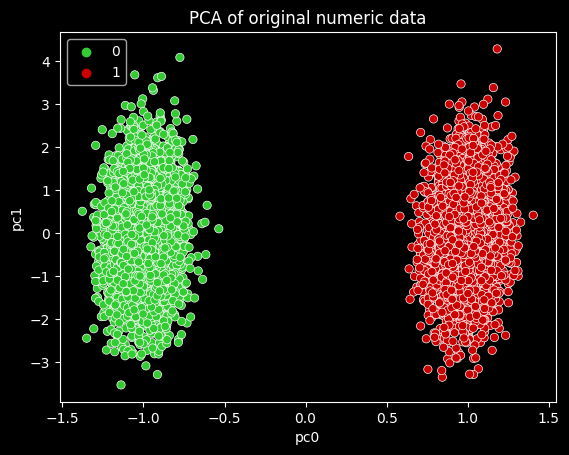

In [229]:
# 8.1 PCA from original train data:

plt.style.use("dark_background")
sns.scatterplot(data = orig_pca ,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["#33cc33", "#cc0000"]
                ).set(title='PCA of original numeric data');


In [235]:
trans_pca

,pc0,pc1
0,1.068825,-0.737957
1,0.802261,-0.300708
2,0.971541,0.429601
3,-0.344806,0.251525
4,-0.775687,-2.217632
...,...,...
8995,-0.942951,-0.629240
8996,0.969554,0.165267
8997,0.952734,-0.026615
8998,0.968173,-0.043291


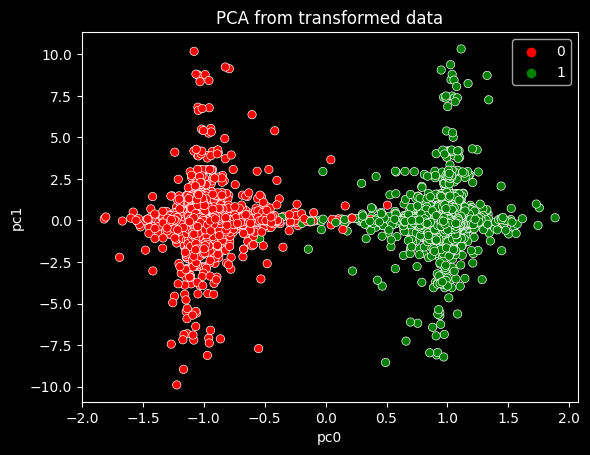

In [236]:
# 8.2 PCA from transformed data:

plt.style.use("dark_background")
sns.scatterplot(data = trans_pca,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green", "white"]
                ).set(title='PCA from transformed data') ;

## xgboost modeling:

In [159]:
# 9.0 Original train/test data:

evals_result= {}
model_orig = xgb.XGBClassifier( n_estimators= 200,
                               verbosity = 3,
                               eta = 0.06,      
                               max_depth = 6,
                               subsample = 0.8, 
                               evals_result = evals_result,
                               random_state = None,
                              )


tr_X =   orig_train
test_X = orig_test
ytr = ytr 
yte = yte 


model_orig.fit(tr_X, ytr.values,             
               early_stopping_rounds = 50,   
               eval_set=[ (tr_X, ytr.values), (test_X, yte.values)], 
               eval_metric = ['auc']        
              )



[21:48:52] WARNING: ../src/learner.cc:767: 
Parameters: { "evals_result" } are not used.

[21:48:52] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[21:48:52] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[21:48:52] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[21:48:52] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[0]	validation_0-auc:1.00000	validation_1-auc:1.00000
[21:48:52] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[21:48:52] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[21:48:52] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[1]	validation_0-auc:1.00000	validation_1-auc:1.00000
[21:48:52] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 e

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              evals_result={}, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None, ...)

In [160]:
# 9.1 Scores:

f"Best auc from orig train/test data: {model_orig.best_score}"
print("\n===========\n")
f"Best iteration from orig train/test data: {model_orig.best_iteration}"

'Best auc from orig train/test data: 1.0'

'Best iteration from orig train/test data: 0'

In [161]:
# 9.2 Modeling with transformed train/test data:

evals_result= {}
model_trans = xgb.XGBClassifier( n_estimators= 300,
                           verbosity = 3,
                           eta = 0.06,      
                           max_depth = 14,
                           subsample = 0.9,        
                           evals_result = evals_result,
                           random_state = None,
                           )


tr_X =   train_trans[fe_1[:5]] #.iloc[:,len(cat_cols):]
test_X = test_trans[fe_1[:5]] # .iloc[:,len(cat_cols):]
ytr = ytr 
yte = yte 


model_trans.fit(tr_X, ytr.values,     
          early_stopping_rounds = 100, 
          eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
          eval_metric = ['auc']    
          )



[21:49:00] WARNING: ../src/learner.cc:767: 
Parameters: { "evals_result" } are not used.

[21:49:00] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[21:49:00] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=7
[21:49:00] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[21:49:00] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[0]	validation_0-auc:1.00000	validation_1-auc:1.00000
[21:49:00] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=7
[21:49:00] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[21:49:00] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[1]	validation_0-auc:1.00000	validation_1-auc:1.00000
[21:49:00] INFO: ../src/tree/updater_prune.cc:98: tree pruning end,

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              evals_result={}, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None, ...)

### Learning curve plots

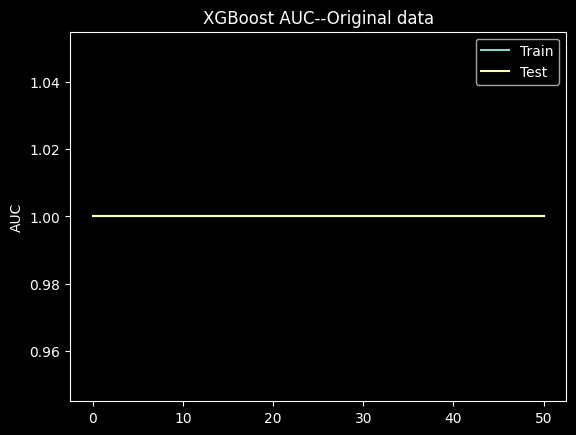

In [162]:
# 9.3 Modeling with original data:

# Ref: https://stackoverflow.com/a/60366515
results = model_orig.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
fig, ax = plt.subplots();
ax.plot(x_axis, results['validation_0']['auc'], label='Train');
ax.plot(x_axis, results['validation_1']['auc'], label='Test');
ax.legend();
plt.ylabel('AUC');
plt.title('XGBoost AUC--Original data');
plt.show();

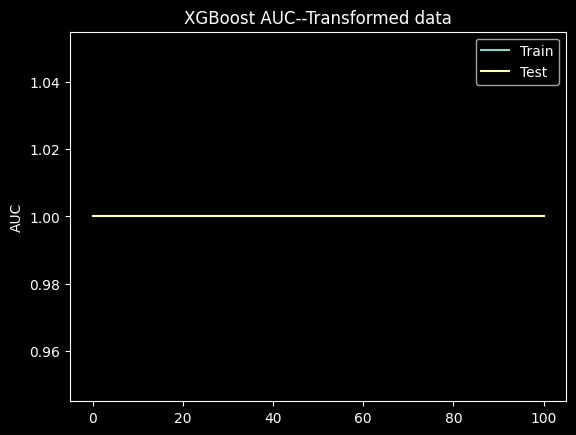

In [163]:
# 9.4 Modeling with transformed data:

results = model_trans.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
fig, ax = plt.subplots();
ax.plot(x_axis, results['validation_0']['auc'], label='Train');
ax.plot(x_axis, results['validation_1']['auc'], label='Test');
ax.legend();
plt.ylabel('AUC');
plt.title('XGBoost AUC--Transformed data');
plt.show();

In [164]:
# 9.5
f"Best auc from transformed train/test data: {model_trans.best_score}"
print("\n===========\n")
f"Best iteration from transformed train/test data: {model_trans.best_iteration}"

'Best auc from transformed train/test data: 1.0'

'Best iteration from transformed train/test data: 0'

## Feature importance
Extract feature importance using function `utils.xgImptFeatures()`. The function outputs three objects as follows::  
>`fe_1`: List of columns arranged in order of descending xgboost impt(feat-impt >0)<br>
>`fe_0`: List of columns whose xgboost importance is zero<br>
>`fe`: One-column dataframe of feature importance(top-down). Col name is 'imp'<br>  

In [165]:
# 10.0 Get feature importance:
#      fe: Sorted Pandas DataFrame with column name and top-down feature impt 

fe_1, fe_0, fe = utils.xgImptFeatures(model_trans,  train_trans.iloc[:,len(cat_cols):].columns)
print("\n=== DataFrame  of impt features top-down =======\n")
fe.iloc[:5]
print("\n\n== Column-list whose feat impt >0 =======\n")
fe_1[:5]  # Arranged in descending order of impt
print("\n\n===Column-list whose feat impt is 0 =======\n")
fe_0[:5]


Order of feature importance is by 'gain'

=== DataFrame  of impt features top-down =======



,imp
eig_a_ck_b,0.721989
deg_a_ck_b,0.202937
deg_a_ck_c,0.075074
eig_a_ck_c,0.000000




== Column-list whose feat impt >0 =======



['eig_a_ck_b', 'deg_a_ck_b', 'deg_a_ck_c']



===Column-list whose feat impt is 0 =======



['eig_a_ck_c']

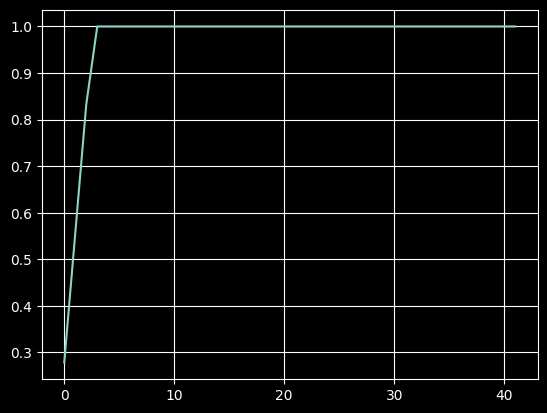

In [114]:
# 10.1 Cumulative sum of feature importance.
#      Last 100 columns have zero or (near zero)
#      importance:

plt.plot(range(len(fe)), fe['imp'].cumsum().values);
plt.grid();

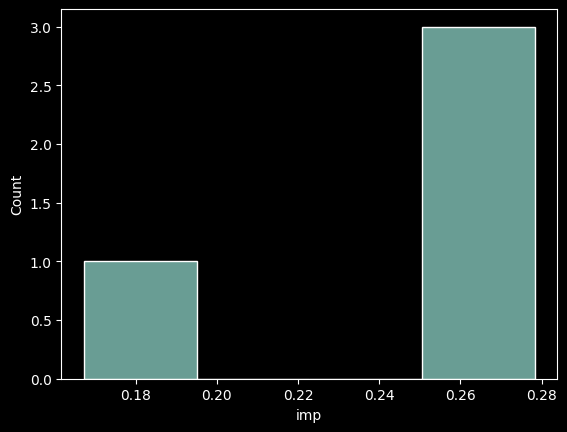

In [115]:
# 10.2 A histogram plot of feature importance score
#      Most columns have feature impt below 0.01

sns.histplot(fe['imp'][fe_1]);

## Correlation with orig columns
Correlation of extracted features with original features

In [62]:
# 11.0 Take top 5 imp features:

tt = train_trans[fe_1[:10]].copy()
tt.shape  # (373, 5)

(373, 10)

In [63]:
# 11.1 Reindex orig_train and merge with 'tt':

ot= orig_train.reset_index(drop = True).copy()
result = ot.merge(tt, left_index = True, right_index=True )


Correlation heatmap shows good amount of correlation between the two sets of features

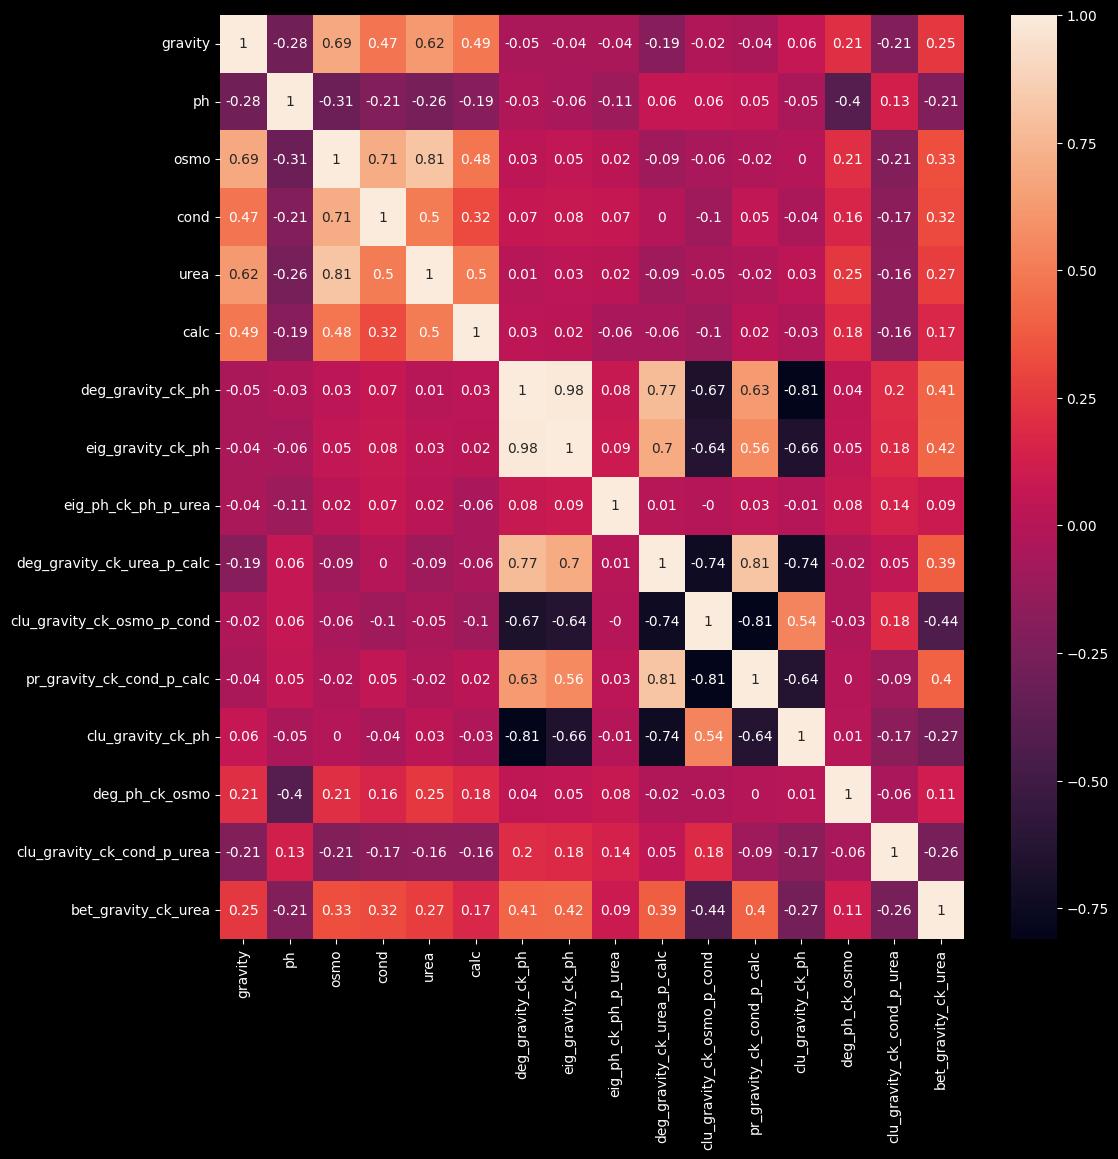

In [64]:
# 11.2 Correlation heatmap:

plt.figure(figsize = (12,12))
sns.heatmap(np.round(result.corr(),2), annot = True);

## Distribution of columns
Distribution of columns related to different centrality measures

### Proportion of columns by centrality measure:

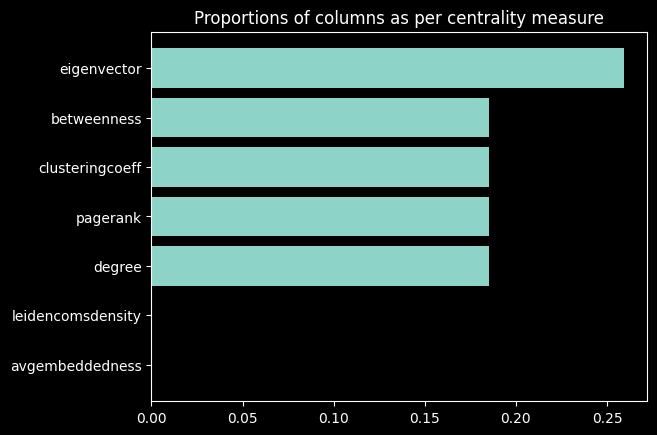

In [ ]:
# 12.0 Our list of columns

colList = (train_trans.iloc[:,len(cat_cols):]).columns

# Count of columns by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(colList, normalize = True)
utils.plotSeries(f, "Proportions of columns as per centrality measure")

### Proportions of columns by centrality whose impt is > 0

In [ ]:
# 12.1 Extract column importance:

fe_1, fe_0,_ = utils.xgImptFeatures(model_trans, colList)
f"Columns whose impt is >0: {len(fe_1)}"
print("\n")
f"Columns whose impt is 0: {len(fe_0)}"


Order of feature importance is by 'gain'


'Columns whose impt is >0: 147'

'Columns whose impt is 0: 123'

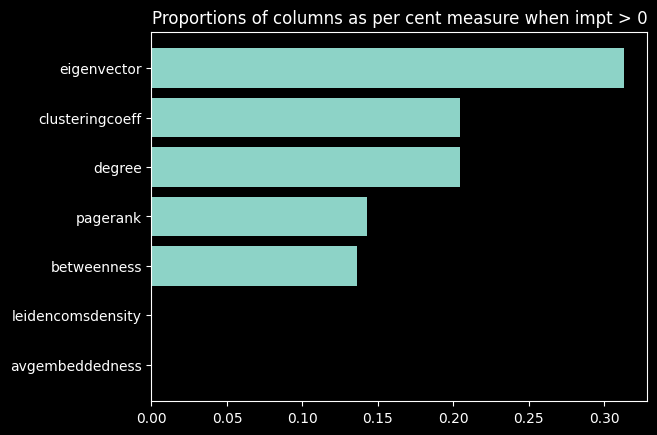

In [ ]:
# 12.2 Count of columns whose xgboost impt > 0 by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(fe_1, normalize = True)
utils.plotSeries(f, "Proportions of columns as per cent measure when impt > 0")

### Proportions of columns by summed-up importance score of each centrality measure

In [ ]:
# 13.0 Extract xgboost feature importance:
fe_1, _, fe = utils.xgImptFeatures(model_trans, colList)



Order of feature importance is by 'gain'


In [ ]:
# 13.1 Column-wise importance score (whose impt > 0)
#      score is a Pandas Series
score = fe['imp'][fe_1]

# 13.2 Score of top-five columns:
score[:5]

eig_concavity_mean_ck_texture_mean                 0.074974
deg_area_se_ck_texture_mean                        0.074818
deg_concavity_mean_ck_concavity_worst              0.050471
clu_area_mean_ck_area_se                           0.037946
eig_concavity_worst_ck_area_mean_p_texture_mean    0.027861
Name: imp, dtype: float32

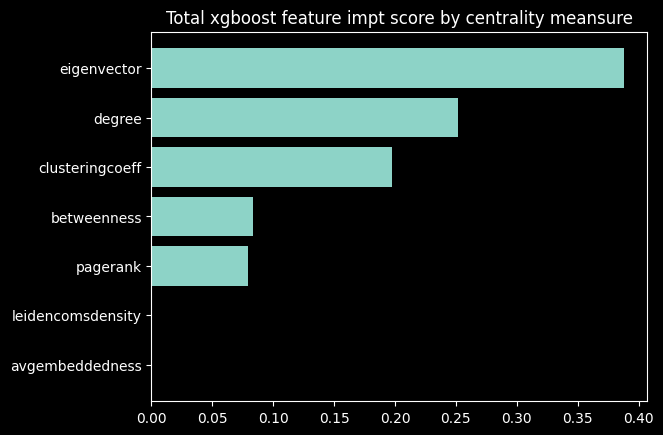

In [ ]:
# 13.3 Extract and plot total xgboost impt scores by centrality measure:

g = utils.featureImptByScore(score, fe_1, True)
utils.plotSeries(g, "Total xgboost feature impt score by centrality meansure")

## Mutual information

In [ ]:
from sklearn.feature_selection import mutual_info_classif



In [ ]:
mi_scores = utils.calMIScores(train_trans[colList], ytr)
mi_scores[::3]  # show a few features with their MI scores

eig_area_mean_ck_concavity_worst_p_concavity_mean       0.411510
eig_area_mean_ck_area_mean_p_area_se                    0.398181
eig_area_mean_ck_area_mean_p_texture_mean               0.396951
eig_area_mean_ck_area_se_p_concavity_worst              0.388818
eig_area_mean_ck_area_mean_p_concavity_worst            0.386731
                                                          ...   
deg_texture_mean_ck_concavity_worst_p_concavity_mean    0.048080
eig_area_se_ck_concavity_worst                          0.043185
deg_texture_mean_ck_area_mean_p_concavity_worst         0.032534
bet_texture_mean_ck_area_se                             0.011870
pr_texture_mean_ck_area_se                              0.000000
Name: MI Scores, Length: 90, dtype: float64

In [ ]:
fe.cumsum()
len(fe)